In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/energy_data.csv')

In [3]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957301 entries, 0 to 1957300
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   building_id        int64  
 1   timestamp          object 
 2   site_id            int64  
 3   primary_use        object 
 4   square_feet        int64  
 5   year_built         float64
 6   floor_count        float64
 7   air_temperature    float64
 8   cloud_coverage     float64
 9   dew_temperature    float64
 10  precip_depth_1_hr  float64
 11  target             float64
dtypes: float64(7), int64(3), object(2)
memory usage: 179.2+ MB


,building_id,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,target
0,107,2016-01-01 00:00:00,1,Education,97532,2005.0,10.0,3.8,0.0,2.4,0.0,175.1840
1,108,2016-01-01 00:00:00,1,Education,81580,1913.0,5.0,3.8,0.0,2.4,0.0,91.2653
2,109,2016-01-01 00:00:00,1,Education,56995,1953.0,6.0,3.8,0.0,2.4,0.0,80.9300
3,110,2016-01-01 00:00:00,1,Education,27814,2006.0,8.0,3.8,0.0,2.4,0.0,86.2283
4,111,2016-01-01 00:00:00,1,Education,118338,1909.0,7.0,3.8,0.0,2.4,0.0,167.3920


In [4]:
# Check for missing values
df.isnull().sum()

building_id          0
timestamp            0
site_id              0
primary_use          0
square_feet          0
year_built           0
floor_count          0
air_temperature      0
cloud_coverage       0
dew_temperature      0
precip_depth_1_hr    0
target               0
dtype: int64

Site_id - signifies the site where the data was collected. The target variable is energy consumption in kWh.

2. Number of observations by day
This is something interesting. We can see that number of observations by day is not the same in the training set.

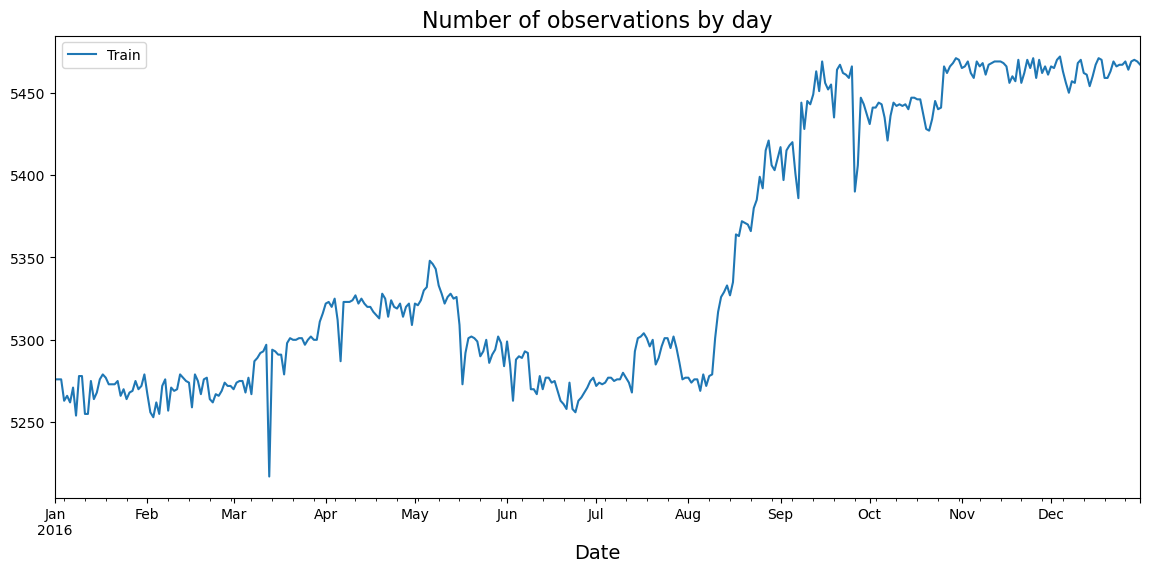

In [5]:
# Ensure 'timestamp' is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plot the data
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
df['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14)
axes.set_title('Number of observations by day', fontsize=16)
axes.legend(['Train', 'Test'])

/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_87518/2562577264.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_index = pd.date_range(start='2016-01-01', end='2016-12-31', freq='H')


Dataset final contém 127 edifícios com dados completos.


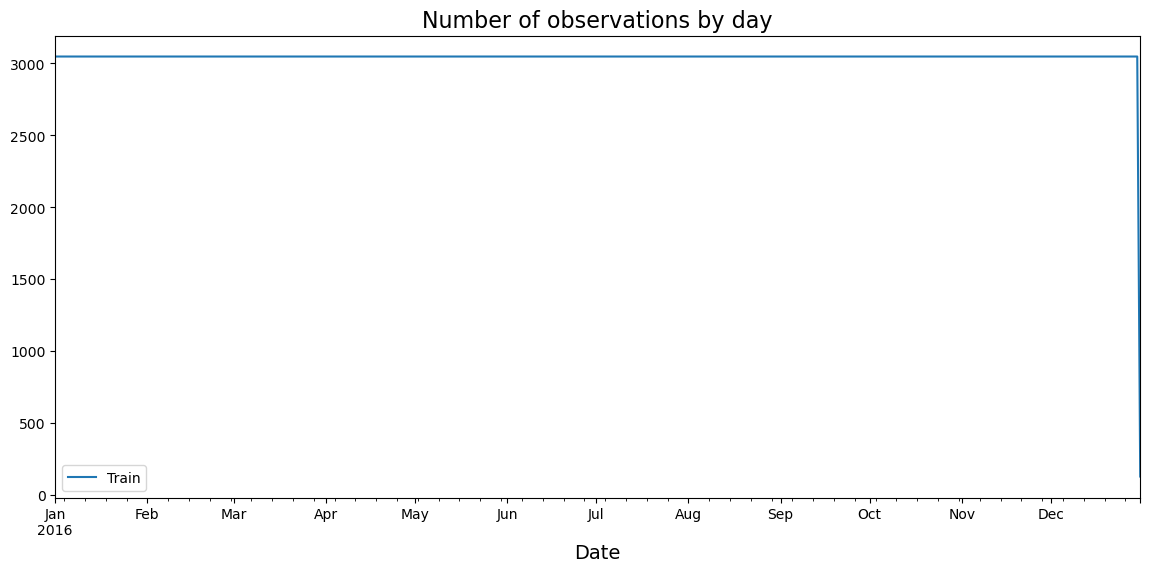

In [6]:
# Primeiro, garantir que 'timestamp' é datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extrair todos os building_id únicos
buildings = df['building_id'].unique()

# Criar o intervalo de tempo para o ano
full_time_index = pd.date_range(start='2016-01-01', end='2016-12-31', freq='H')

# Criar um DataFrame com todas as combinações possíveis
full_index = pd.MultiIndex.from_product(
    [buildings, full_time_index],
    names=['building_id', 'timestamp']
)

# Reindexar o dataframe original para ter todas as combinações
df = df.set_index(['building_id', 'timestamp']).reindex(full_index).reset_index()

df['day'] = df['timestamp'].dt.date

# Verificar se há dias com target faltante por building_id
nan_days = df.groupby(['building_id', 'day'])['target'].apply(lambda x: x.isna().any()).reset_index(name='has_nan')

# Encontrar os buildings com pelo menos um dia com target a NaN
buildings_with_nan_days = nan_days[nan_days['has_nan']]['building_id'].unique()

# Remover esses buildings do dataset
df = df[~df['building_id'].isin(buildings_with_nan_days)].copy()

# (Opcional) remover a coluna 'day'
df.drop(columns='day', inplace=True)

# --- Verifica se está limpo ---
print(f"Dataset final contém {df['building_id'].nunique()} edifícios com dados completos.")

# Preencher os valores ausentes com interpolação

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
df['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
axes.set_title('Number of observations by day', fontsize=16);
axes.legend(['Train', 'Test']);

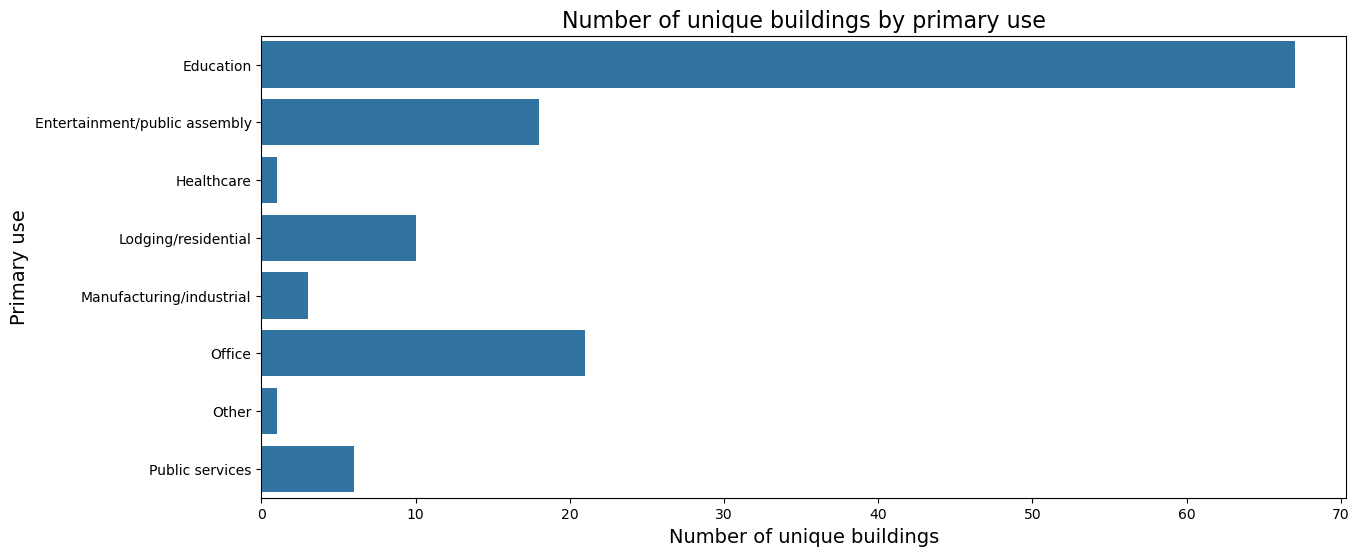

In [7]:
from matplotlib.ticker import FuncFormatter

# Agrupar e contar unique buildings por primary_use
building_counts = df[['building_id', 'primary_use']].drop_duplicates().groupby('primary_use').count().reset_index()
building_counts = building_counts.rename(columns={'building_id': 'building_count'})

# Plot
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.barplot(data=building_counts, y='primary_use', x='building_count', ax=axes)

axes.set_ylabel('Primary use', fontsize=14)
axes.set_xlabel('Number of unique buildings', fontsize=14)
axes.set_title('Number of unique buildings by primary use', fontsize=16)

# Format x-axis to show numbers with commas
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
axes.xaxis.set_major_formatter(formatter)


In [8]:
# Vamos eliminar os edificios que tem primary use in ('other', 'healthcare', 'manufacturing')
df = df[~df['primary_use'].isin(['Other', 'Healthcare', 'Manufacturing/industrial'])].copy()

In [9]:
# education_buildings = df[df['primary_use'] == 'Education']
# target_variable = 'target'  # Nome da variável target
# cv_per_building = education_buildings.groupby('building_id')[target_variable].agg(
#     mean='mean', std='std')

# cv_per_building['cv'] = cv_per_building['std'] / cv_per_building['mean']
# cv_per_building = cv_per_building.sort_values(by='cv', ascending=False)
# top_40_buildings = cv_per_building.head(40)
# undersampled_education_buildings = education_buildings[education_buildings['building_id'].isin(top_40_buildings.index)]

# print(f"Number of buildings: {undersampled_education_buildings['building_id'].nunique()}")

# plt.figure(figsize=(10, 6))
# sns.boxplot(x='building_id', y='target', data=undersampled_education_buildings)
# plt.title('Dispersão do Target para os 40 Edifícios com Maior Coeficiente de Variação', fontsize=16)
# plt.xlabel('ID do Edifício', fontsize=12)
# plt.ylabel('Valor do Target', fontsize=12)
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

# concatenar todos os dataframes
#df = pd.concat([df[df['primary_use'] != 'Education'], undersampled_education_buildings], ignore_index=True)

# Code to do the undersampling

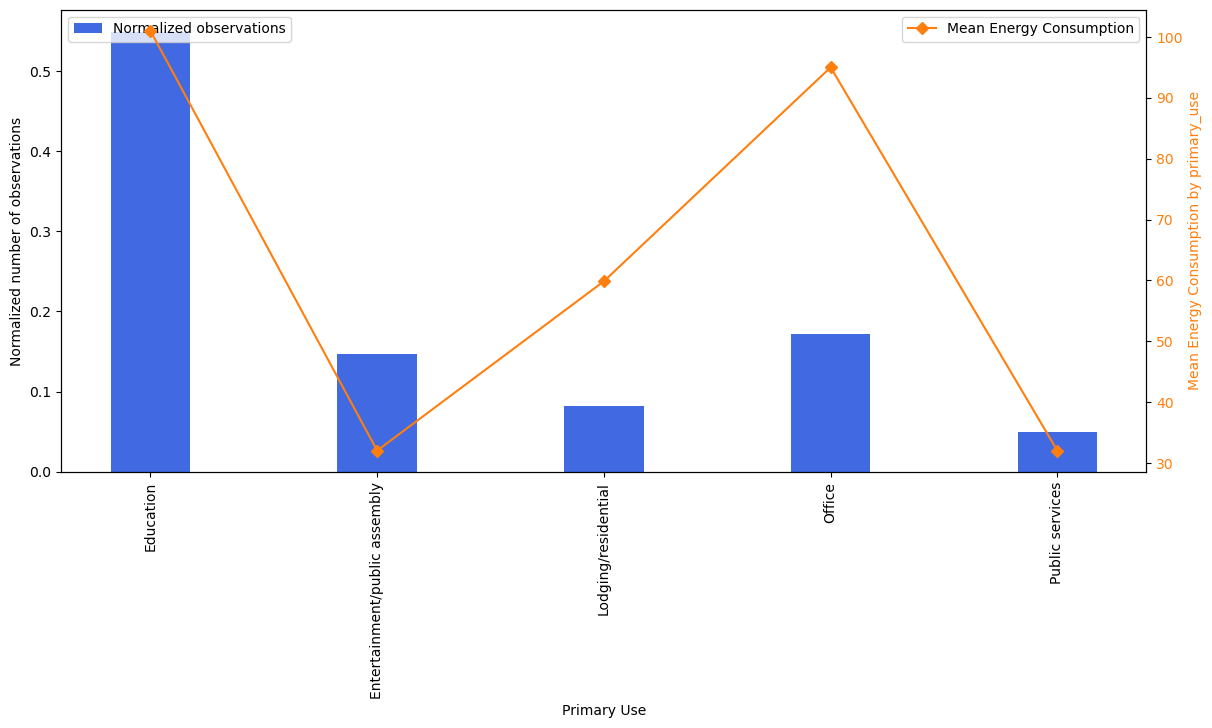

In [10]:
train_data = df['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(figsize=(14, 6), dpi=100)
bars = axes.bar(ind, train_data, width, color='royalblue', label='Normalized observations')

axes.set_ylabel('Normalized number of observations')
axes.set_xlabel('Primary Use')
axes.set_xticks(ind)
axes.set_xticklabels(df['primary_use'].value_counts().sort_index().index, rotation=90)

# Segundo eixo Y para a média de meter_reading
axes2 = axes.twinx()
mean_meter_reading = df.groupby('primary_use')['target'].mean().sort_index().values
line = axes2.plot(ind, mean_meter_reading, 'D-', color='tab:orange', label='Mean Energy Consumption')

axes2.set_ylabel('Mean Energy Consumption by primary_use', color='tab:orange')
axes2.tick_params(axis='y', labelcolor='tab:orange')
axes2.grid(False)

# Ajustando a legenda
axes.legend(loc='upper left', facecolor='white')
axes2.legend(loc='upper right', facecolor='white')

plt.show()


/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_87518/2701258961.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  site_data['air_temperature'].resample('H').mean().plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_87518/2701258961.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  site_data['air_temperature'].resample('H').mean().plot(


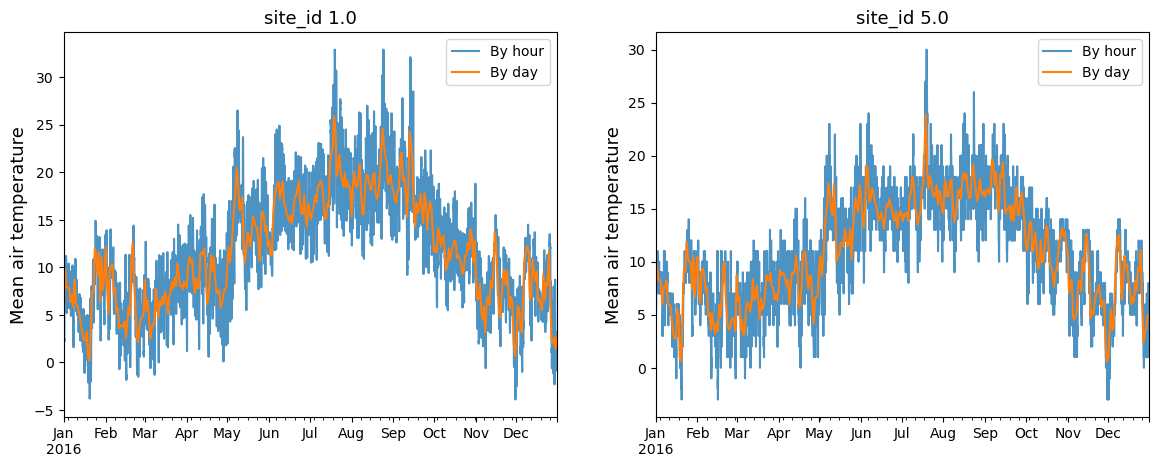

In [11]:
# Ensure 'timestamp' is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plot temperature data for each site
unique_sites = df['site_id'].unique()
num_sites = len(unique_sites)
rows = (num_sites + 1) // 2  # Calculate the number of rows needed
cols = 2  # Two columns for the subplots

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows), dpi=100)
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, site_id in enumerate(unique_sites):
    ax = axes.flatten()[i]
    
    # Filter data for the current site
    site_data = df[df['site_id'] == site_id].set_index('timestamp')
    
    # Plot hourly mean air temperature
    site_data['air_temperature'].resample('H').mean().plot(
        ax=ax, alpha=0.8, label='By hour', color='tab:blue'
    ).set_ylabel('Mean air temperature', fontsize=13)
    
    # Plot daily mean air temperature
    site_data['air_temperature'].resample('D').mean().plot(
        ax=ax, alpha=1, label='By day', color='tab:orange'
    ).set_xlabel('')
    
    ax.legend()
    ax.set_title(f'site_id {site_id}', fontsize=13)

plt.subplots_adjust(hspace=0.45)
plt.show()

Number of unique sites: 2


/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_87518/2089187983.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  site_data[['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_87518/2089187983.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  site_data[['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(


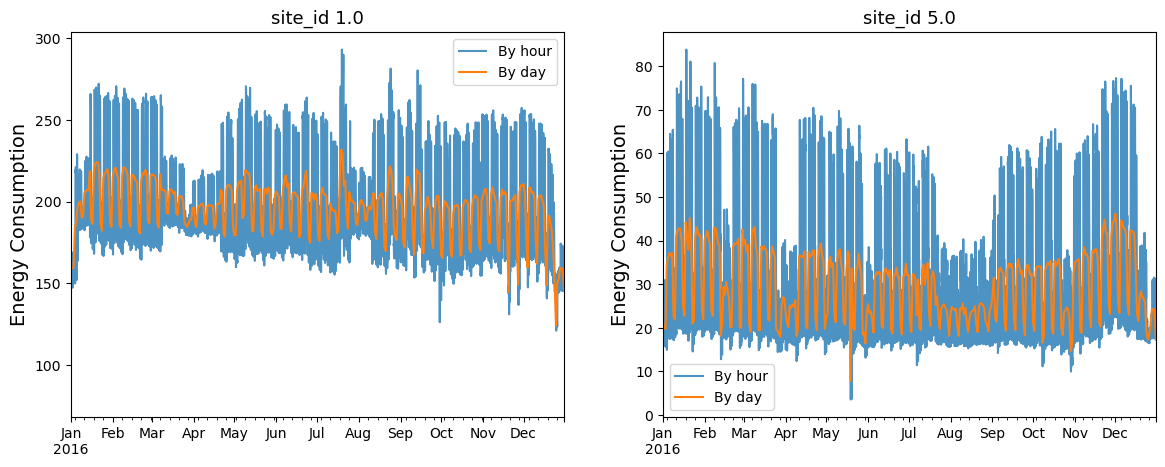

In [12]:
num_sites = len(unique_sites)
rows = (num_sites + 1) // 2  # Calculate the number of rows needed
cols = 2  # Two columns for the subplots

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows), dpi=100)
axes = axes.flatten()  # Flatten the axes array for easier indexing

print(f'Number of unique sites: {num_sites}')
for i, site_id in enumerate(unique_sites):
    ax = axes[i]

    site_data = df[df['site_id'] == site_id]
    if site_data.empty:
        print(f"No data for site_id {site_id}")
        continue

    site_data[['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
        ax=ax, alpha=0.8, label='By hour', color='tab:blue'
    ).set_ylabel('Energy Consumption', fontsize=14)

    site_data[['timestamp', 'target']].set_index('timestamp').resample('D').mean()['target'].plot(
        ax=ax, alpha=1, label='By day', color='tab:orange'
    ).set_xlabel('')

    ax.legend()
    ax.set_title(f'site_id {site_id}', fontsize=13)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(hspace=0.45)
plt.show()


1. Mean target variable (energy consumption) for each month

/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_87518/1353294898.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Target', fontsize=14)


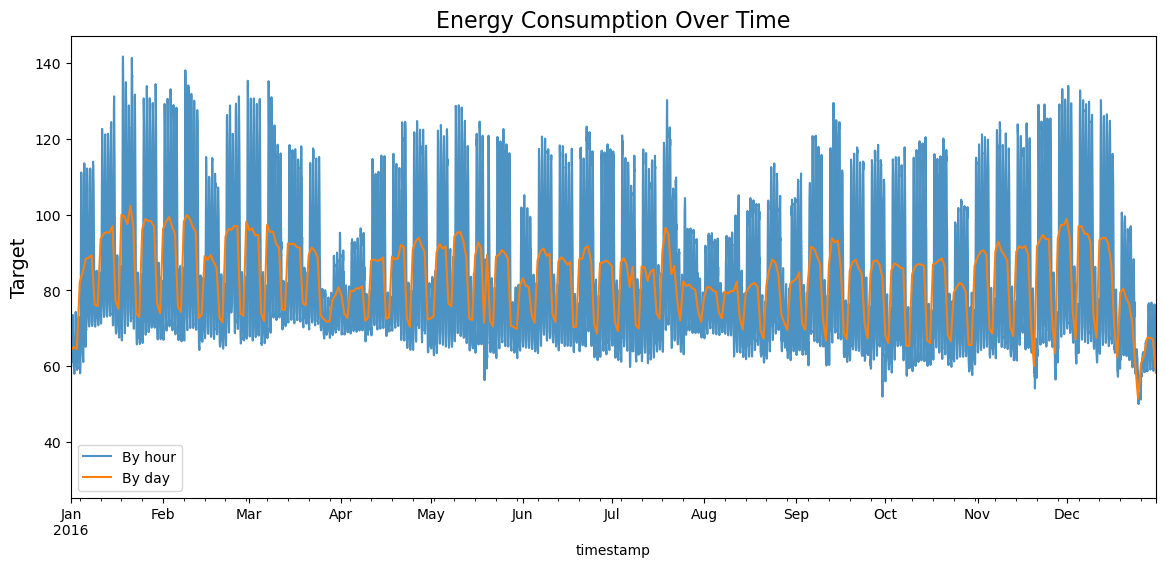

In [13]:
# Ensure the timestamp column is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plot the data
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
df[['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Target', fontsize=14)
df[['timestamp', 'target']].set_index('timestamp').resample('D').mean()['target'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Target', fontsize=14)
axes.set_title('Energy Consumption Over Time', fontsize=16)
axes.legend()

/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_87518/4203739592.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['primary_use'] == primary_use][['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_87518/4203739592.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['primary_use'] == primary_use][['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_87518/4203739592.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['primary_use'] == primary_use][['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_87518/4203739592.py:8: Future

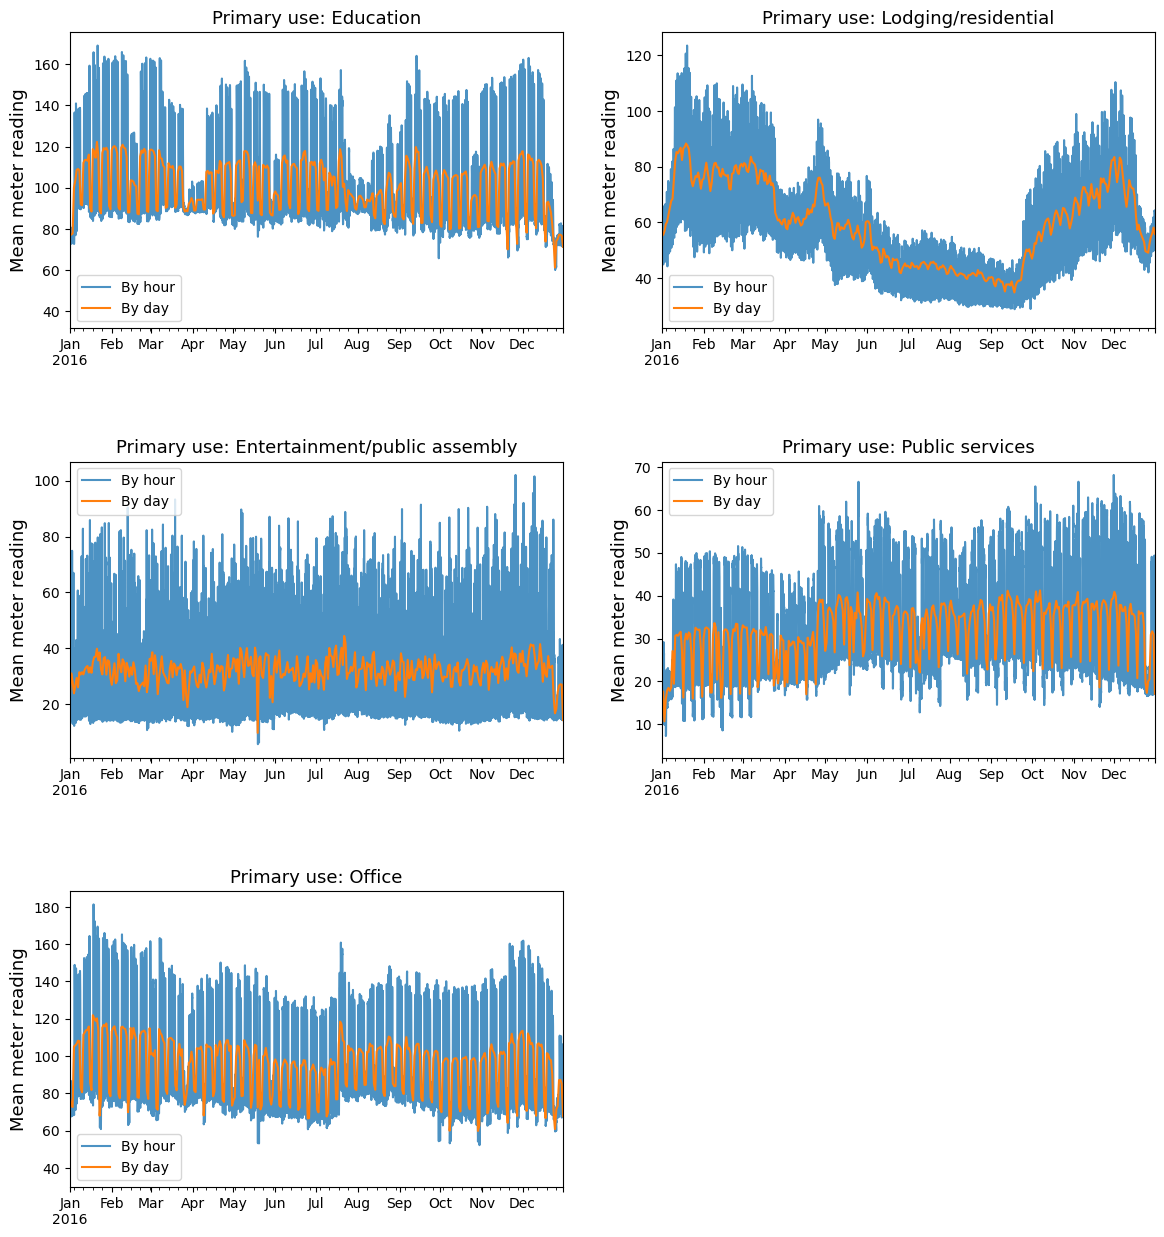

In [14]:
primary_use_types = df['primary_use'].unique()

fig, axes = plt.subplots(3, 2, figsize=(14, 15), dpi=100)

for i, primary_use in enumerate(primary_use_types):
    ax = axes[i // 2, i % 2]  # Corrected index calculation

    df[df['primary_use'] == primary_use][['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
        ax=ax, alpha=0.8, label='By hour', color='tab:blue'
    )
    
    df[df['primary_use'] == primary_use][['timestamp', 'target']].set_index('timestamp').resample('D').mean()['target'].plot(
        ax=ax, alpha=1, label='By day', color='tab:orange'
    )

    ax.set_ylabel('Mean meter reading', fontsize=13)
    ax.set_xlabel('')
    ax.legend()
    ax.set_title(f'Primary use: {primary_use}', fontsize=13)

plt.subplots_adjust(hspace=0.45)
# Remove unused subplots
for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])
plt.show()



O gráfico de barras mostra a contagem de cada categoria, enquanto o gráfico de linha mostra a média do consumo para cada categoria. Isso ajuda a entender como o consumo varia entre as diferentes categorias de uso primário.

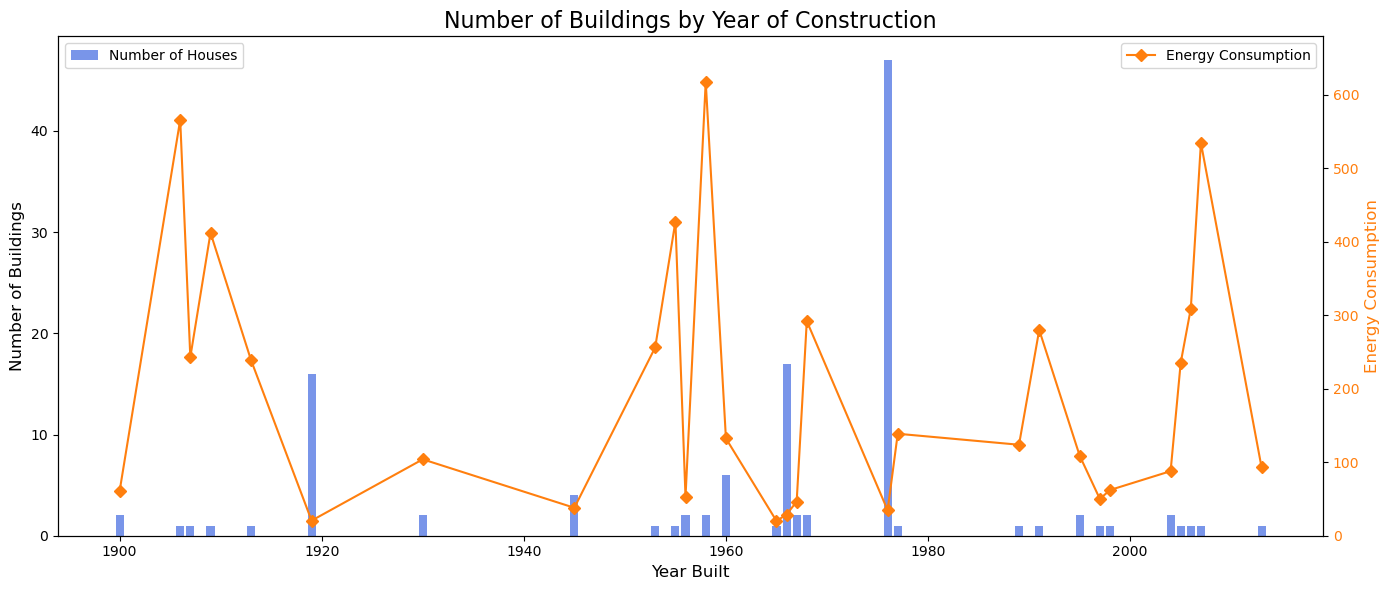

In [15]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Number of houses by year of construction (bars)
year_counts = df.groupby('year_built')['building_id'].nunique()
ax.bar(year_counts.index, year_counts.values, color='royalblue', alpha=0.7, label='Number of Houses')

ax.set_xlabel('Year Built', fontsize=12)
ax.set_ylabel('Number of Buildings', fontsize=12)
ax.set_title('Number of Buildings by Year of Construction', fontsize=16)

# Mean energy consumption by year of construction (line)
ax2 = ax.twinx()
mean_meter_reading = df.groupby('year_built')['target'].mean()
ax2.plot(mean_meter_reading.index, mean_meter_reading.values, 'D-', color='tab:orange', label='Energy Consumption')
ax2.set_ylim(0, mean_meter_reading.max() * 1.1)  # Adjust y-axis limits for clarity

ax2.set_ylabel('Energy Consumption', fontsize=12, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Adjust legends
ax.legend(loc='upper left', facecolor='white')
ax2.legend(loc='upper right', facecolor='white')

plt.tight_layout()
plt.show()

/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_87518/1415638634.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=floor_count_distribution, x='floor_count', y='building_id', ax=ax, palette='viridis')


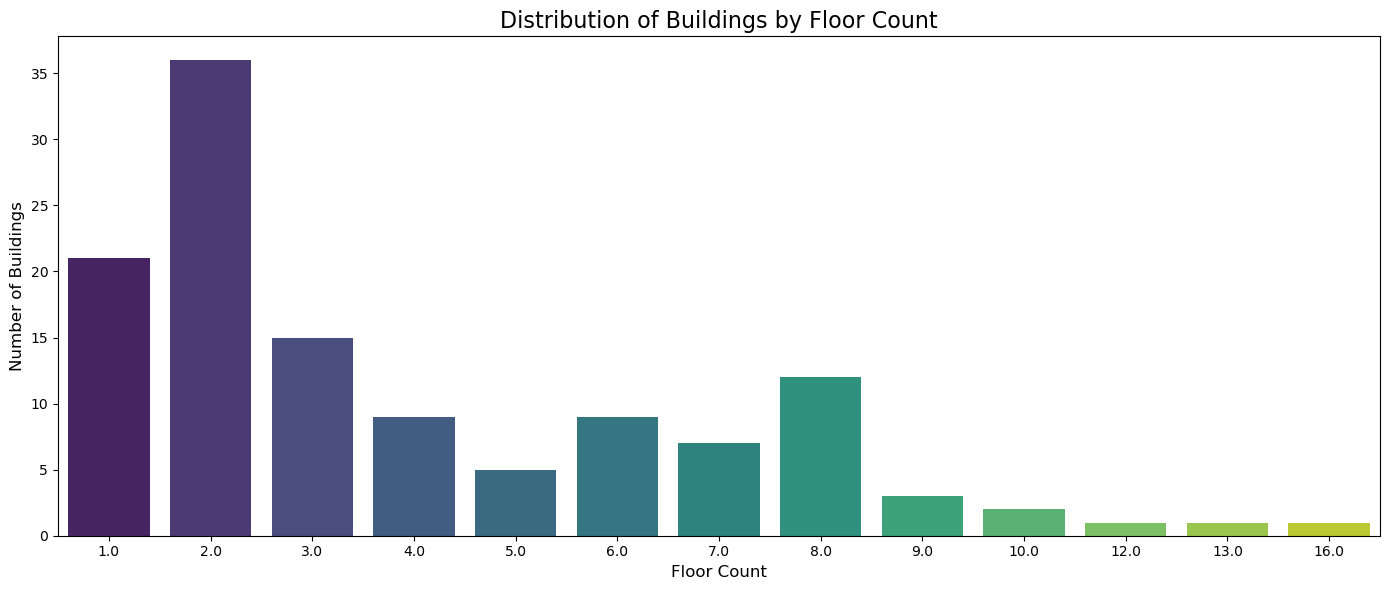

In [16]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)
floor_count_distribution = df.groupby('floor_count')['building_id'].nunique().reset_index()

sns.barplot(data=floor_count_distribution, x='floor_count', y='building_id', ax=ax, palette='viridis')

ax.set_xlabel('Floor Count', fontsize=12)
ax.set_ylabel('Number of Buildings', fontsize=12)
ax.set_title('Distribution of Buildings by Floor Count', fontsize=16)
plt.tight_layout()
plt.show()


# Feature Engineering


In [17]:
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday
df['month'] = df['timestamp'].dt.month

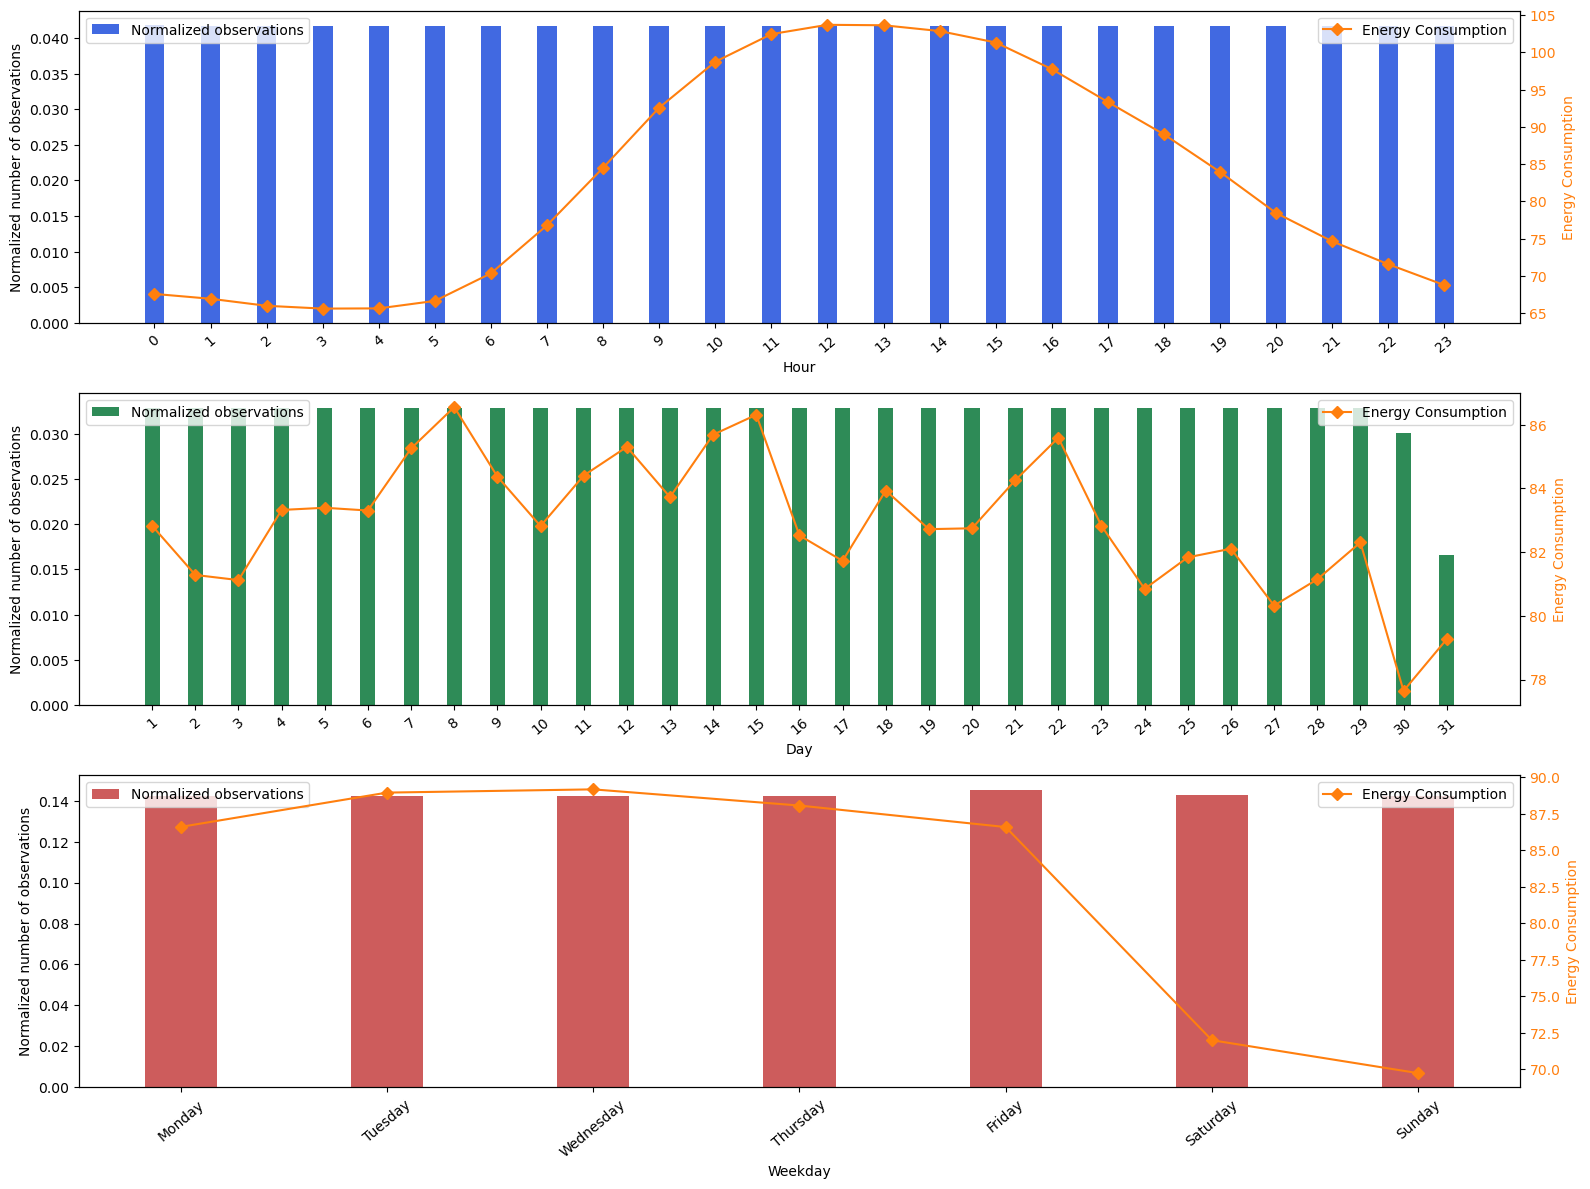

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12), dpi=100)

time_units = ['hour', 'day', 'weekday']
titles = ['Hour', 'Day', 'Weekday']
colors = ['royalblue', 'seagreen', 'indianred']

weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

for i, unit in enumerate(time_units):
    train_data = df[unit].value_counts(dropna=False, normalize=True).sort_index().values
    ind = np.arange(len(train_data))
    width = 0.35

    bars = axes[i].bar(ind, train_data, width, color=colors[i], label='Normalized observations')
    
    axes[i].set_ylabel('Normalized number of observations')
    axes[i].set_xlabel(titles[i])
    axes[i].set_xticks(ind)
    if unit == 'weekday':
        labels = df[unit].value_counts().sort_index().index.map(weekday_map)
        axes[i].set_xticklabels(labels, rotation=40)
    else:
        axes[i].set_xticklabels(df[unit].value_counts().sort_index().index, rotation=40)

    # Segundo eixo Y para a média de meter_reading
    ax2 = axes[i].twinx()
    mean_meter_reading = df.groupby(unit)['target'].mean().sort_index().values
    line = ax2.plot(ind, mean_meter_reading, 'D-', color='tab:orange', label='Energy Consumption')

    ax2.set_ylabel('Energy Consumption', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.grid(False)

    # Ajustando a legenda
    axes[i].legend(loc='upper left', facecolor='white')
    ax2.legend(loc='upper right', facecolor='white')

plt.tight_layout()
plt.show()


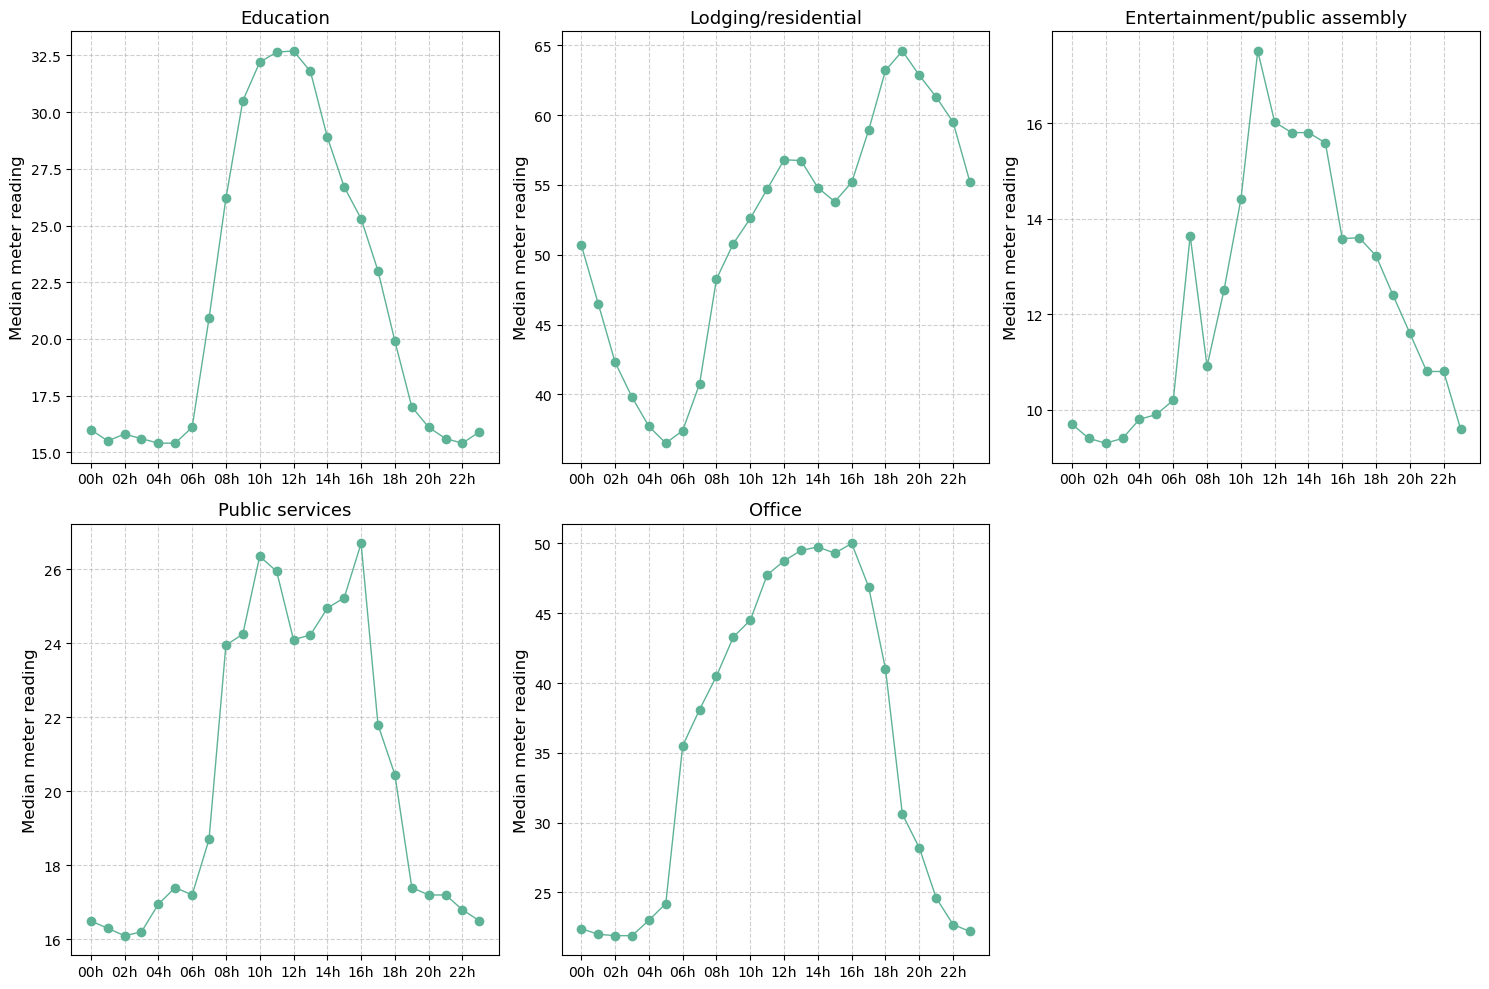

In [19]:
df_grouped = df.groupby(['hour', 'primary_use'])['target'].median().reset_index()

unique_primary_uses = df['primary_use'].unique()
num_plots = len(unique_primary_uses)

cols = 3
rows = -(-num_plots // cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), dpi=100)
axes = axes.flatten()

for i, primary_use in enumerate(unique_primary_uses):
    ax = axes[i]
    df_filtered = df_grouped[df_grouped['primary_use'] == primary_use]
    ax.plot(df_filtered['hour'], df_filtered['target'], marker='o', linestyle='-', color="#5EB296", linewidth=1)
    ax.set_title(f'{primary_use}', fontsize=13)
    ax.set_ylabel('Median meter reading', fontsize=12)
    ax.set_xticks(range(0, 24, 2))
    ax.set_xticklabels(["00h", "02h", "04h", "06h", "08h", "10h", "12h", "14h", "16h", "18h", "20h", "22h"])
    ax.grid(True, linestyle='--', alpha=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


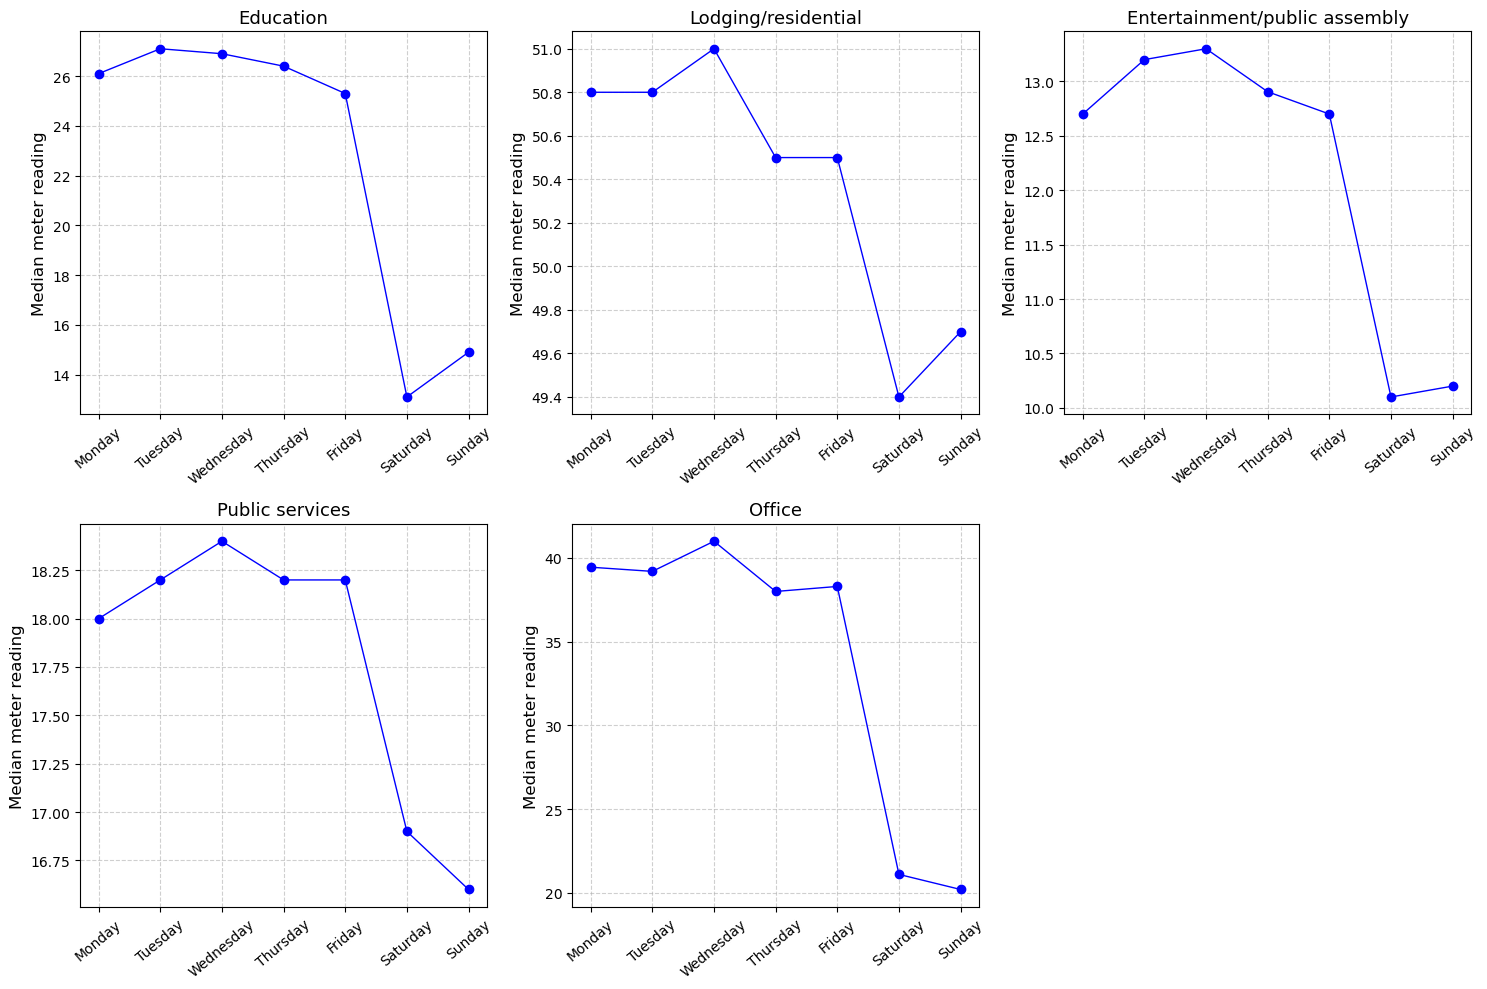

In [20]:
df_grouped_weekday = df.groupby(['weekday', 'primary_use'])['target'].median().reset_index()

unique_primary_uses = df['primary_use'].unique()
num_plots = len(unique_primary_uses)

cols = 3
rows = -(-num_plots // cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), dpi=100)
axes = axes.flatten()

for i, primary_use in enumerate(unique_primary_uses):
    ax = axes[i]
    df_filtered = df_grouped_weekday[df_grouped_weekday['primary_use'] == primary_use]
    ax.plot(df_filtered['weekday'], df_filtered['target'], marker='o', linestyle='-', color="blue", linewidth=1)
    ax.set_title(f'{primary_use}', fontsize=13)
    ax.set_ylabel('Median meter reading', fontsize=12)
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=40)
    ax.grid(True, linestyle='--', alpha=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [21]:
# cria uma variavel de m2/andar isto é o que ja existe(square_feet,year_built,floor_count)
df['m2_per_floor'] = df['square_feet'] / df['floor_count']
df['m2_per_floor'].fillna(0, inplace=True)


/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_87518/1547257455.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['m2_per_floor'].fillna(0, inplace=True)


In [22]:
# to see the null values
print(df.isnull().sum())
print(df.isna().sum())

building_id          0
timestamp            0
site_id              0
primary_use          0
square_feet          0
year_built           0
floor_count          0
air_temperature      0
cloud_coverage       0
dew_temperature      0
precip_depth_1_hr    0
target               0
hour                 0
day                  0
weekday              0
month                0
m2_per_floor         0
dtype: int64
building_id          0
timestamp            0
site_id              0
primary_use          0
square_feet          0
year_built           0
floor_count          0
air_temperature      0
cloud_coverage       0
dew_temperature      0
precip_depth_1_hr    0
target               0
hour                 0
day                  0
weekday              0
month                0
m2_per_floor         0
dtype: int64


In [23]:
def create_lags(df, lags, columns):
    df = df.sort_values(by=["building_id", "timestamp"])  # Garantir a ordenação correta
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df.groupby("building_id")[col].shift(lag)
    return df

# Definir os lags em horas
lags = [1, 6, 12, 24 * 3, 24 * 5, 24 * 7]  # 3 dias, 5 dias e 7 dias convertidos para horas

# Definir as colunas para as quais vamos criar lags
columns = ['target', 'air_temperature']

# Criar os lags para as colunas selecionadas
df = create_lags(df, lags, columns)

# Remover as linhas com valores NaN gerados pelos lags
df.dropna(inplace=True)
# to see the null values
print(df.isnull().sum())
print(df.isna().sum())


building_id                0
timestamp                  0
site_id                    0
primary_use                0
square_feet                0
year_built                 0
floor_count                0
air_temperature            0
cloud_coverage             0
dew_temperature            0
precip_depth_1_hr          0
target                     0
hour                       0
day                        0
weekday                    0
month                      0
m2_per_floor               0
target_lag_1               0
target_lag_6               0
target_lag_12              0
target_lag_72              0
target_lag_120             0
target_lag_168             0
air_temperature_lag_1      0
air_temperature_lag_6      0
air_temperature_lag_12     0
air_temperature_lag_72     0
air_temperature_lag_120    0
air_temperature_lag_168    0
dtype: int64
building_id                0
timestamp                  0
site_id                    0
primary_use                0
square_feet                0
y

In [24]:
print(df['primary_use'].value_counts())

primary_use
Education                        575731
Office                           180453
Entertainment/public assembly    154674
Lodging/residential               85930
Public services                   51558
Name: count, dtype: int64


In [25]:
# criar one-hot encoding para a variavel primary_use
from sklearn.preprocessing import OneHotEncoder

df['primary_use'] = df['primary_use'].astype('category')

# Criar o OneHotEncoder
encoder = OneHotEncoder()

# Ajustar o encoder aos dados
encoder.fit(df[['primary_use']])
# Transformar os dados
encoded_primary_use = encoder.transform(df[['primary_use']]).toarray()
# Obter os nomes das colunas
encoded_columns = encoder.get_feature_names_out(['primary_use'])

# Criar um DataFrame com os dados codificados
encoded_df = pd.DataFrame(encoded_primary_use, columns=encoded_columns, index=df.index)
# Concatenar o DataFrame original com o DataFrame codificado
df = pd.concat([df, encoded_df], axis=1)

# Remover a coluna original
df.drop(columns=['primary_use'], inplace=True)



In [26]:
# sum nan target
nan_target = df['target'].isna().sum()
print(f"Total NaN target values: {nan_target}")
print(df.shape)
# Verificar duplicações de linhas no DataFrame
print(f"Duplicações no DataFrame: {df.duplicated().sum()}")

print(df.isnull().sum())
print(df.isna().sum())


Total NaN target values: 0
(1048346, 33)
Duplicações no DataFrame: 0
building_id                                  0
timestamp                                    0
site_id                                      0
square_feet                                  0
year_built                                   0
floor_count                                  0
air_temperature                              0
cloud_coverage                               0
dew_temperature                              0
precip_depth_1_hr                            0
target                                       0
hour                                         0
day                                          0
weekday                                      0
month                                        0
m2_per_floor                                 0
target_lag_1                                 0
target_lag_6                                 0
target_lag_12                                0
target_lag_72                         

In [27]:
col = 'target'
list_feature = df.columns.tolist()
list_feature.remove(col)
df = df[list_feature + [col]]

# unique site_id != precip_depth_1_hr == 0
print(df[df['precip_depth_1_hr'] != 0]['site_id'].unique())
# logo a precip_depth_1_hr  vai ser sempre 0, podemos eliminar
df.drop(columns='precip_depth_1_hr', inplace=True)

[]


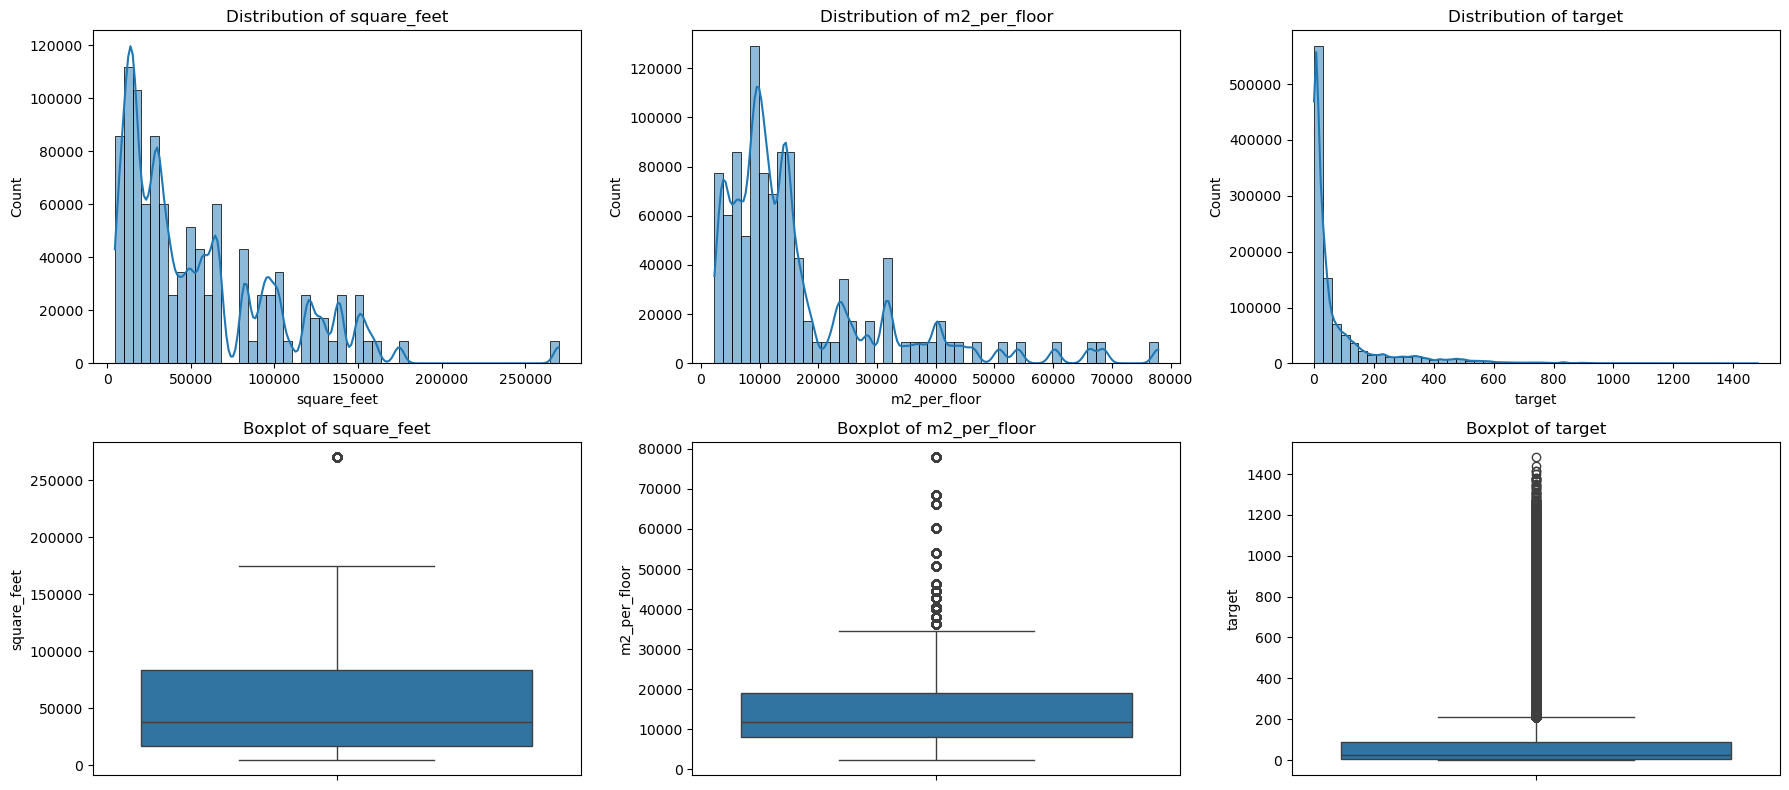

In [28]:
columns = ["square_feet", "m2_per_floor", "target"]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(columns):
    # Histogram with KDE
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    
    # Boxplot
    sns.boxplot(y=df[col], ax=axes[i + 3])
    axes[i + 3].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [29]:

log_cols = ["square_feet", "m2_per_floor", "target"] 
df[log_cols] = np.log1p(df[log_cols])

In [30]:
df.head()

,building_id,timestamp,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,hour,...,air_temperature_lag_12,air_temperature_lag_72,air_temperature_lag_120,air_temperature_lag_168,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Lodging/residential,primary_use_Office,primary_use_Public services,target
168,107,2016-01-08 00:00:00,1.0,11.487946,2005.0,10.0,3.3,0.0,0.9,0,...,8.6,7.4,9.7,3.8,1.0,0.0,0.0,0.0,0.0,5.96397
169,107,2016-01-08 01:00:00,1.0,11.487946,2005.0,10.0,3.2,0.0,1.1,1,...,7.6,8.1,9.3,3.7,1.0,0.0,0.0,0.0,0.0,5.96397
170,107,2016-01-08 02:00:00,1.0,11.487946,2005.0,10.0,2.6,0.0,1.0,2,...,7.9,8.2,8.5,2.6,1.0,0.0,0.0,0.0,0.0,5.96397
171,107,2016-01-08 03:00:00,1.0,11.487946,2005.0,10.0,2.7,0.0,1.2,3,...,7.8,8.3,7.7,2.0,1.0,0.0,0.0,0.0,0.0,5.96397
172,107,2016-01-08 04:00:00,1.0,11.487946,2005.0,10.0,1.9,0.0,0.8,4,...,7.0,6.4,6.8,2.3,1.0,0.0,0.0,0.0,0.0,5.96397


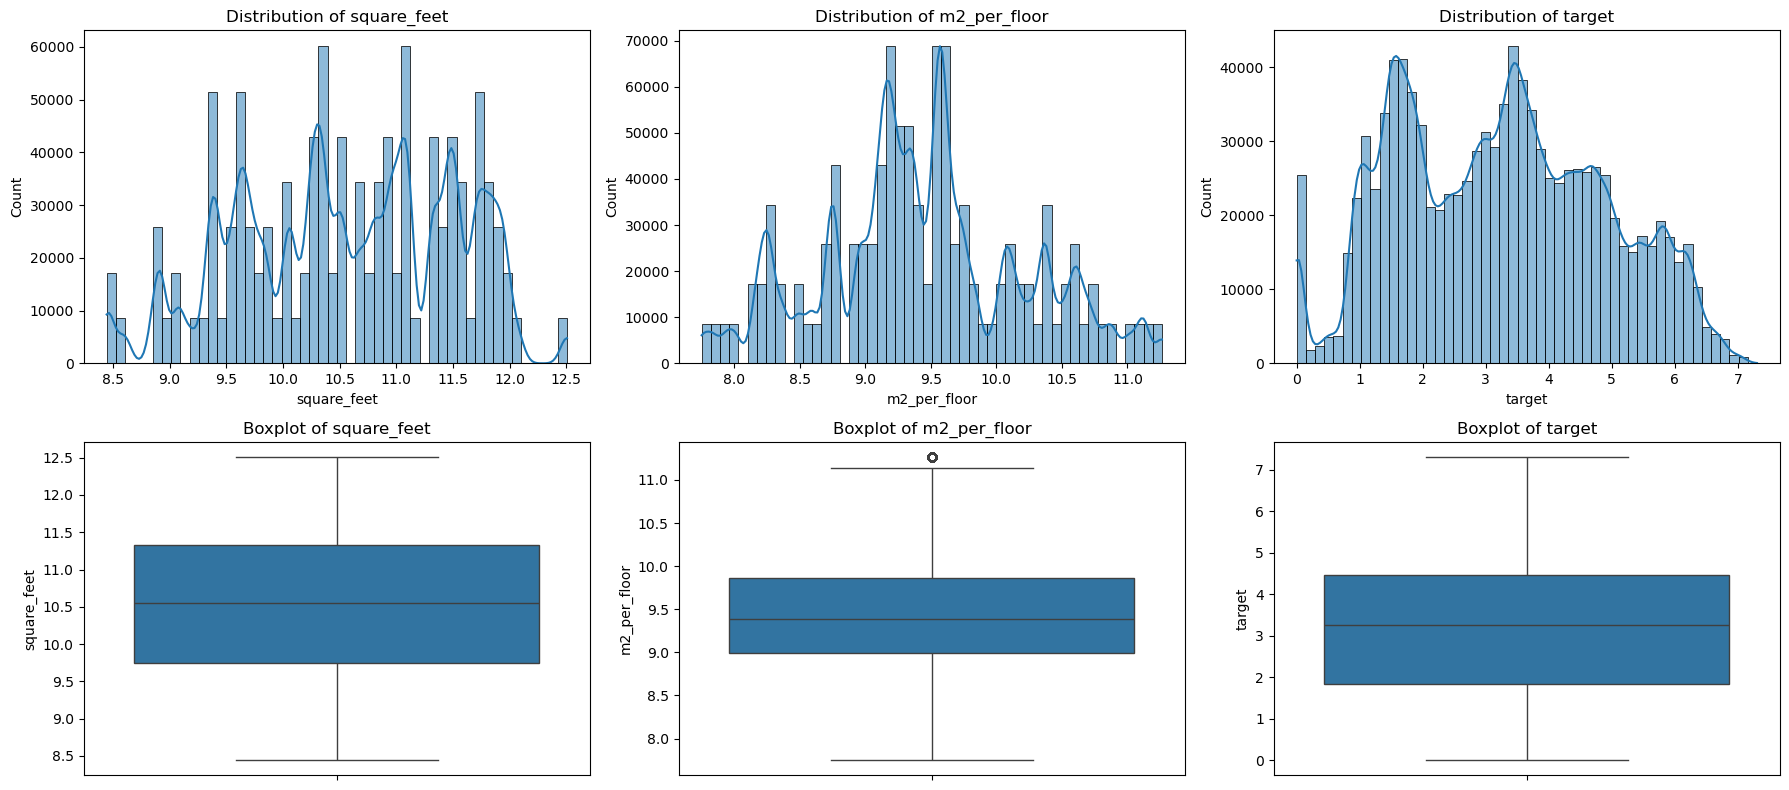

In [31]:
columns = ["square_feet", "m2_per_floor", "target"]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(columns):
    # Histogram with KDE
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    
    # Boxplot
    sns.boxplot(y=df[col], ax=axes[i + 3])
    axes[i + 3].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


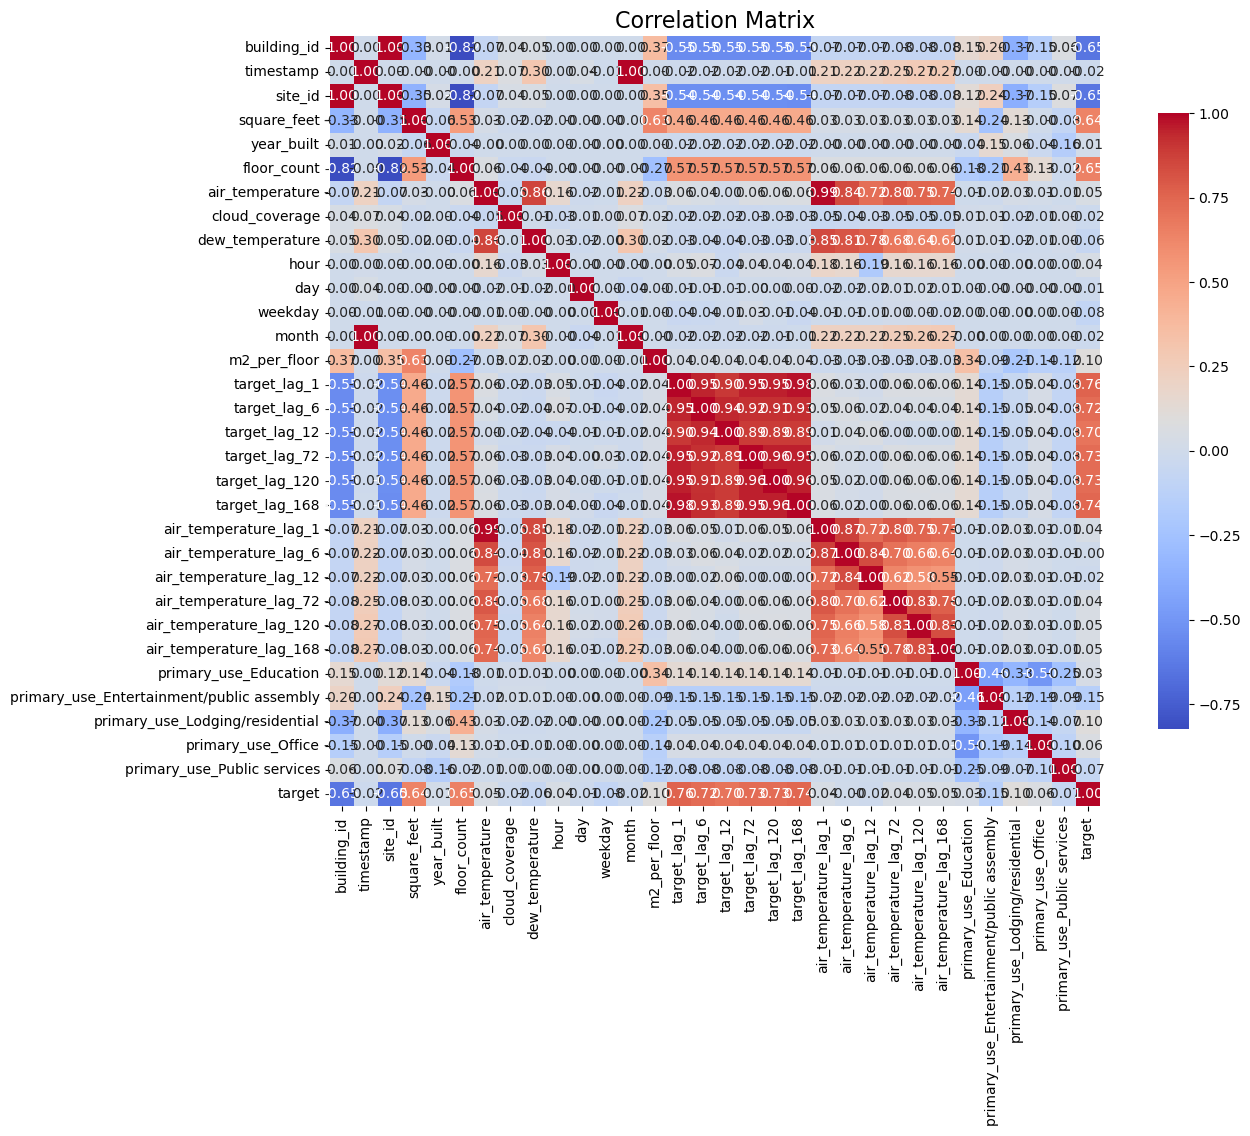

In [32]:
# correlation matrix
corr = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix', fontsize=16)
plt.show()


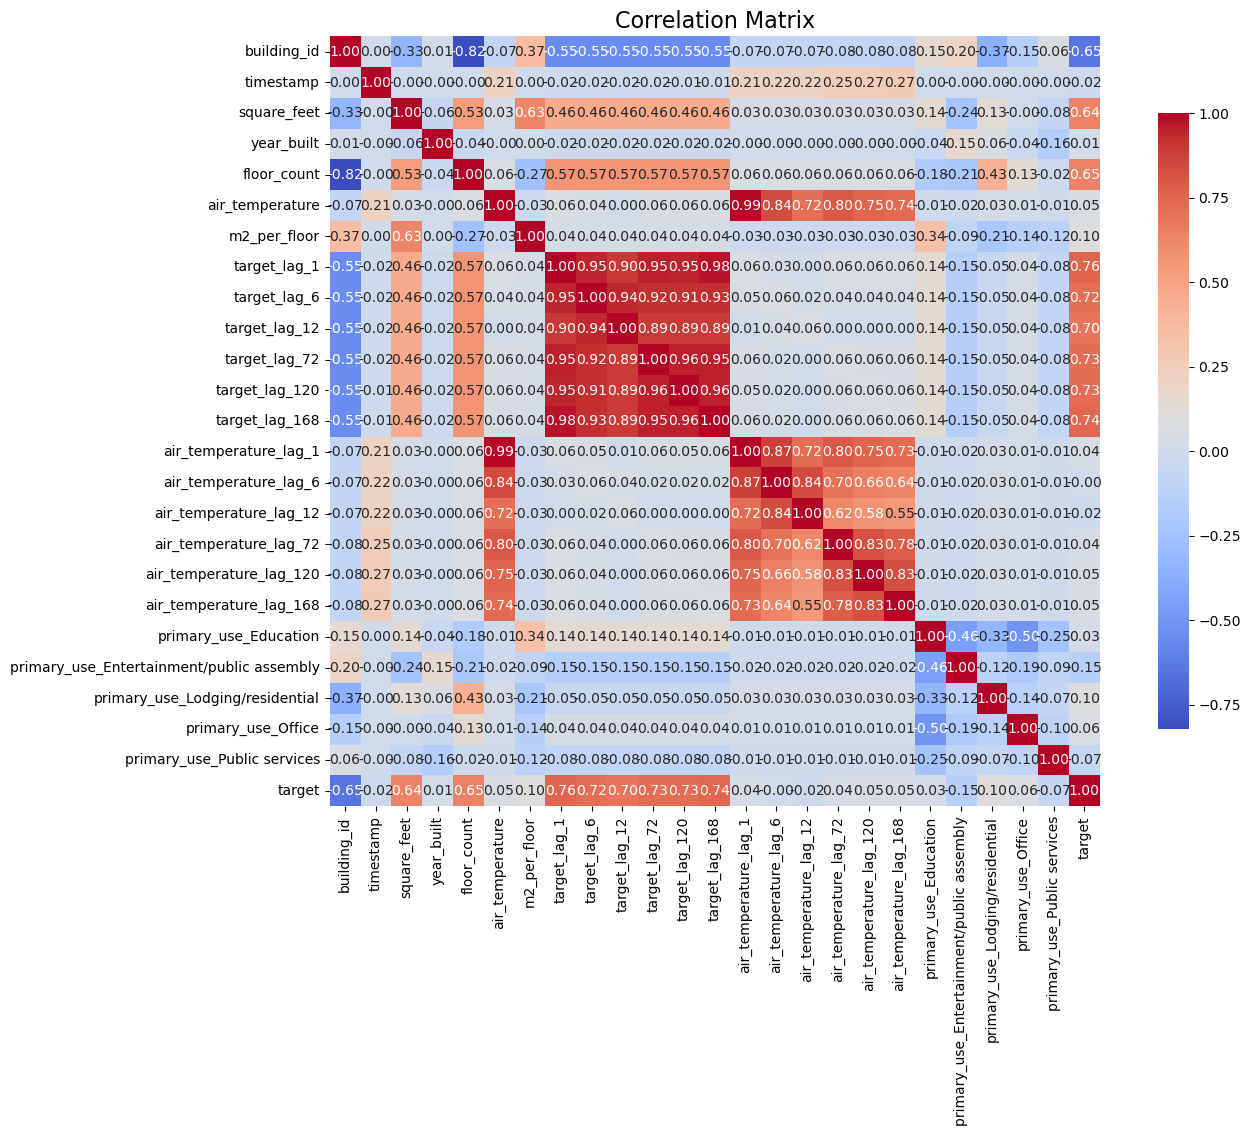

In [33]:
# apagar building_id, site_id, cloud_coverage, precip_depth_1_hr, hour, day, weekday, month
df.drop(columns=['site_id', 'cloud_coverage', 'hour', 'day', 'weekday', 'month', 'dew_temperature'], inplace=True)

corr = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix', fontsize=16)
plt.show()


In [34]:
df.to_csv('../data/energy_data_cleaned_wBuildingId.csv', index=False)

# Summary of Workflow

1. **Data Cleaning**:
    - Checked for missing values using `isnull().sum()` and `isna().sum()`.
    - Converted the `timestamp` column to datetime format for time-based analysis.
    - Dropped unnecessary columns such as `precip_depth_1_hr`, `cloud_coverage`, `hour`, `day`, `weekday`, `month`, and `dew_temperature` after extracting relevant features.
    - Removed buildings with missing target values for entire days.
    - Reindexed the dataset to include all combinations of `building_id` and `timestamp` for the year 2016.

2. **Feature Engineering**:
    - Created new time-based features: `hour`, `day`, `weekday`, and `month`.
    - Calculated `m2_per_floor` as `square_feet / floor_count` to derive a new feature.
    - Encoded categorical variables like `primary_use` using `OneHotEncoder`.
    - Created lag features for `target` and `air_temperature` to capture temporal dependencies.

3. **Data Transformation**:
    - Applied logarithmic transformation to columns (`square_feet`, `m2_per_floor`, `target`) to reduce skewness.
    - Removed outliers and normalized numerical columns where necessary.

4. **Exploratory Data Analysis (EDA)**:
    - Visualized the target variable (`energy consumption`) over time using line plots.
    - Analyzed data by `site_id`, `primary_use`, and `year_built` using bar and line plots.
    - Examined the distribution of `floor_count`, `square_feet`, and other features using histograms and boxplots.
    - Created heatmaps to visualize correlations between features.

5. **Time-Based Analysis**:
    - Grouped data by `hour` and `weekday` to analyze median energy consumption for each `primary_use`.
    - Plotted hourly and weekly trends for different `primary_use` categories.
    - Analyzed the distribution of observations by day and identified inconsistencies in the dataset.

6. **Data Export**:
    - Saved the cleaned and transformed dataset to a new CSV file (`energy_data_cleaned_wBuildingId.csv`) for further use.

This workflow combines data cleaning, feature engineering, and visualization to prepare the dataset for modeling and analysis. It ensures data quality and enhances feature representation for better predictive modeling.